# 1. Get data

In [ ]:
import kagglehub

path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")

print("Path to dataset files:", path)

# 2. Export from matlab and see some samples

Dataset Shapes:
X_tumor: (3064, 256, 256, 1)
Y_tumor_mask: (3064, 256, 256, 1)
Tumor Labels: (3064,)
Unique Labels: [0 1 2]


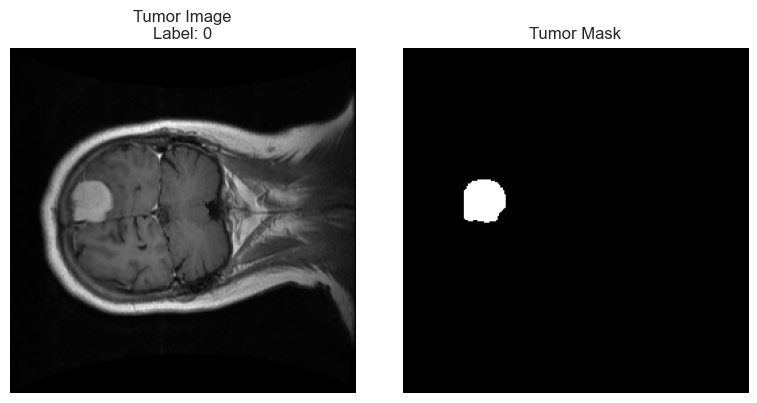

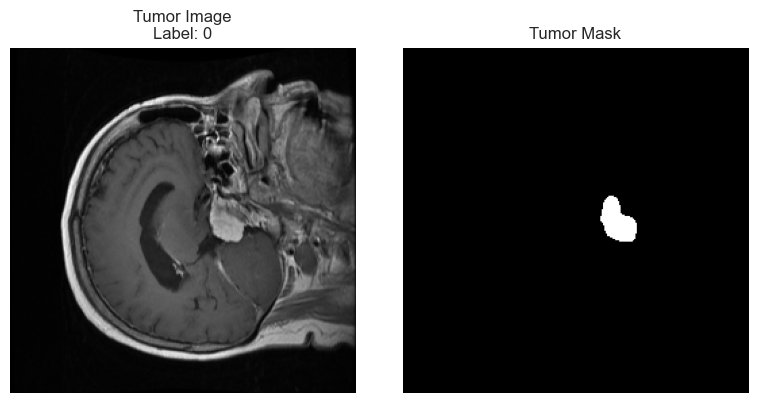

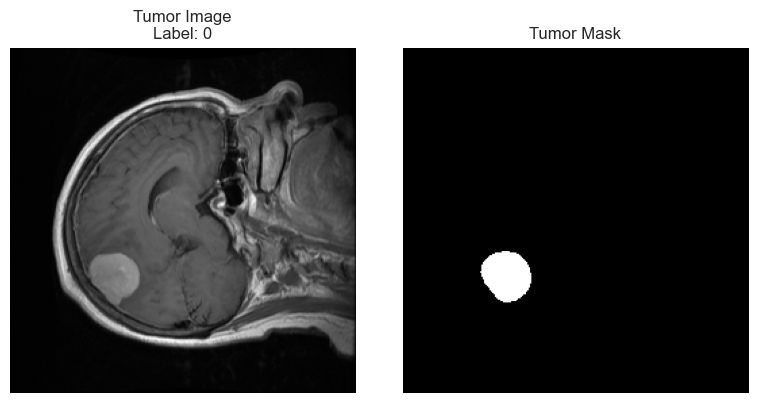

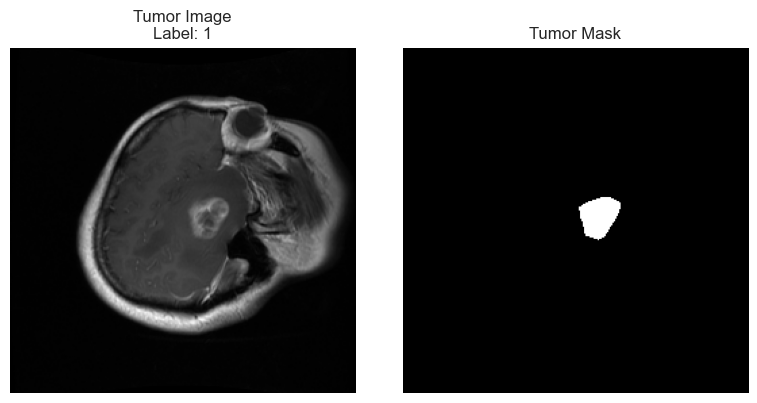

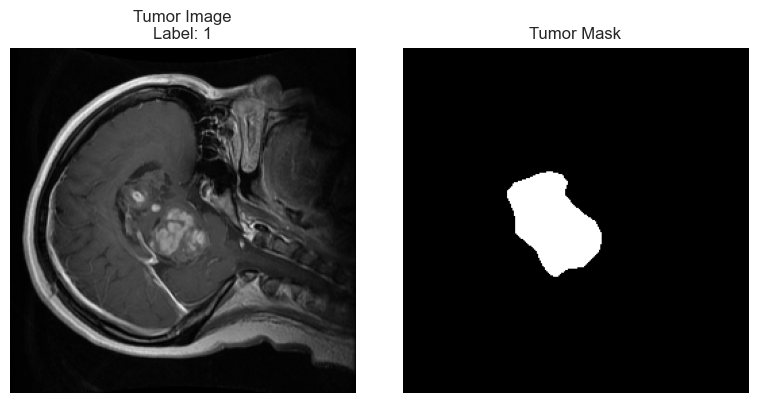

In [1]:
import random
import numpy as np
import h5py
import os
import cv2
import matplotlib.pyplot as plt

# path to dataset
# data_dir = "D:\\BACHELOR THESIS\\dataset\\ashkhagan\\figshare-brain-tumor-dataset\\versions\\1\\dataset\\data" # pt windows
data_dir = "/Users/horiaionescu/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1/dataset/data" # pt mac
total_images = 3064

X_tumor = []
Y_tumor_mask = []
tumor_labels = []


for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    file_path = os.path.join(data_dir, filename)

    # mat file using h5py (for matlab v7.3 files)
    with h5py.File(file_path, "r") as data:
        # tumor image, resize and normalize for model input
        image = np.array(data["cjdata"]["image"])
        image = cv2.resize(image, (256, 256))  # Resize to 256x256 pixels
        image = image / 255.0  # Normalize pixel values to [0, 1]
        X_tumor.append(image)

        # tumor mask, resize and threshold into a binary image
        mask = np.array(data["cjdata"]["tumorMask"])
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.uint8)  # Convert to binary mask
        Y_tumor_mask.append(mask)

        # tumor label (1: Meningioma, 2: Glioma, 3: Pituitary Tumor)
        label = int(np.array(data["cjdata"]["label"])[0][0] - 1)
        tumor_labels.append(label)

# lists to NumPy arrays
# add extra channel dimension (grayscale) for compatibility with most CNNs
X_tumor = np.array(X_tumor).reshape(-1, 256, 256, 1)
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 256, 256, 1)
tumor_labels = np.array(tumor_labels)


print("Dataset Shapes:")
print("X_tumor:", X_tumor.shape)
print("Y_tumor_mask:", Y_tumor_mask.shape)
print("Tumor Labels:", tumor_labels.shape)
print("Unique Labels:", np.unique(tumor_labels))


# visualize

num_samples = 5

sample_indices = random.sample(range(len(X_tumor)), num_samples)

for idx in sample_indices:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_tumor[idx].squeeze(), cmap='gray')
    plt.title(f"Tumor Image\nLabel: {tumor_labels[idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_tumor_mask[idx].squeeze(), cmap='gray')
    plt.title("Tumor Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# 256x256x1 needed for segmentation
# for classification, we'll need 256x256x3 , 3 channel rgb

# 3. Preprocess

Processed X_tumor shape: (3064, 256, 256, 1)


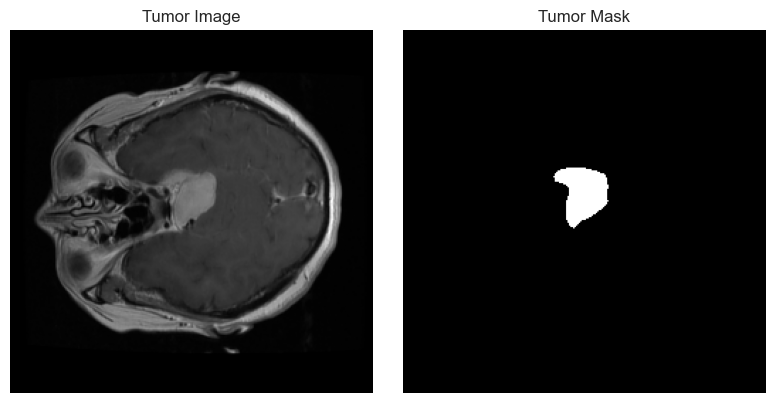

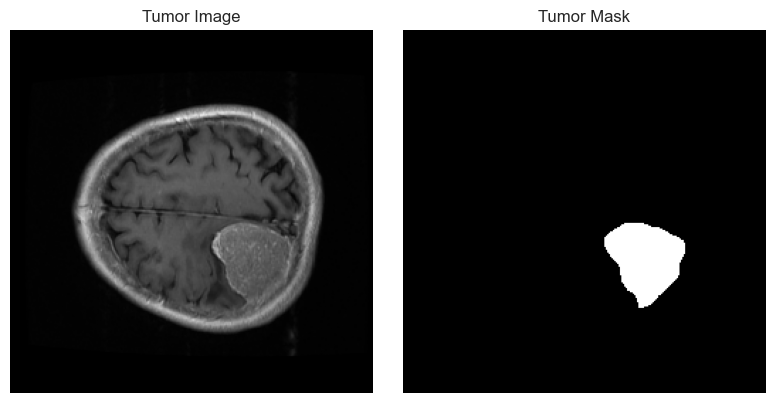

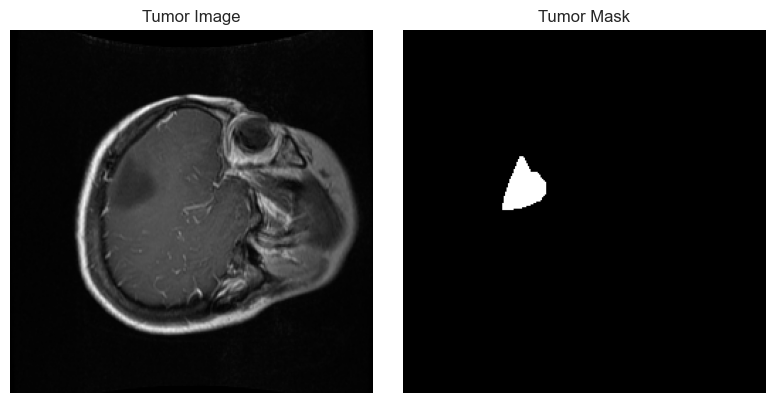

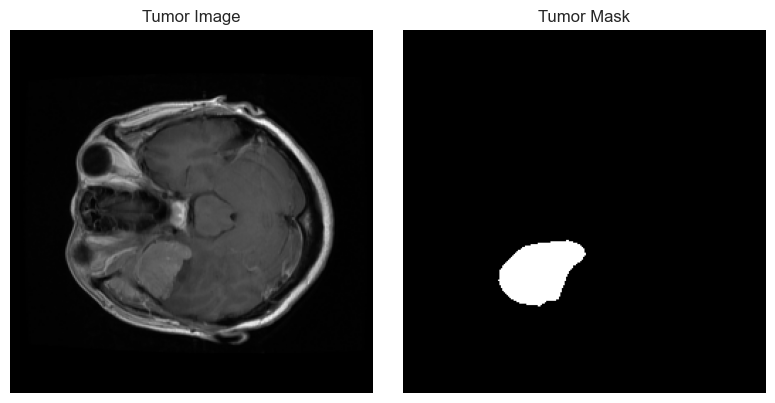

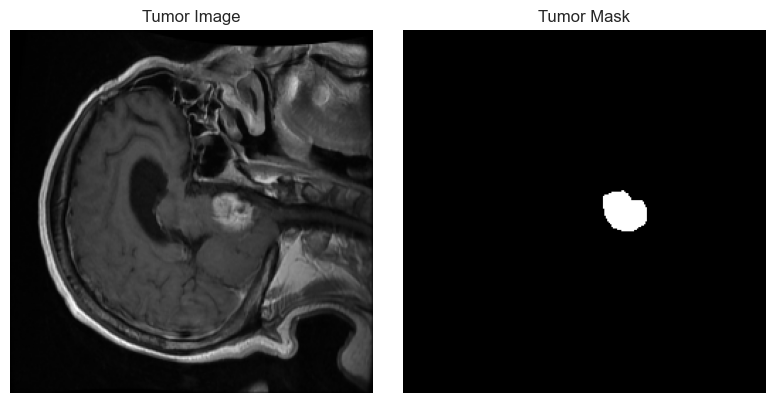

In [2]:
# resize 256x256x1 already done
# normalization already done
# grayscale as well, here we just do a check to ensure all are greyscale
# and padding to ensure uniformity

target_height = 256
target_width = 256

def check_and_pad(image, target_height, target_width):
    current_height, current_width = image.shape[:2]

    # Return image as is if dimensions match target
    if current_height == target_height and current_width == target_width:
        return image

    # Compute required padding
    pad_height = target_height - current_height
    pad_width = target_width - current_width

    if image.ndim == 3:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)),
                              mode='constant', constant_values=0)
    else:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width)),
                              mode='constant', constant_values=0)
    return padded_image

X_tumor_processed = []

for img in X_tumor:
    # If the image has more than one channel, convert it to grayscale.
    if img.ndim == 3 and img.shape[-1] != 1:
        # Convert image from normalized [0,1] range to [0,255] for cv2 conversion.
        img_8bit = (img * 255).astype(np.uint8)
        img_gray = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2GRAY)
        # Normalize back to [0,1] and expand dims to add channel dimension.
        img_gray = img_gray.astype(np.float32) / 255.0
        img = np.expand_dims(img_gray, axis=-1)

    img_2d = img.squeeze()
    img_padded = check_and_pad(img_2d, target_height, target_width)
    img_final = np.expand_dims(img_padded, axis=-1)
    X_tumor_processed.append(img_final)

X_tumor_processed = np.array(X_tumor_processed)
print("Processed X_tumor shape:", X_tumor_processed.shape)

num_samples = 5

sample_indices = random.sample(range(len(X_tumor)), num_samples)

for idx in sample_indices:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_tumor_processed[idx].squeeze(), cmap='gray')
    plt.title(f"Tumor Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_tumor_mask[idx].squeeze(), cmap='gray')
    plt.title("Tumor Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 4. PyTorch Lightning module

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# Custom Dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, images, masks, labels, transform=None):
        """
        images: numpy array of shape (N, 256, 256, 1)
        masks: numpy array of shape (N, 256, 256, 1)
        labels: numpy array of shape (N,)
        """
        self.images = images
        self.masks = masks
        self.labels = labels  # Added labels for classification
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Convert image, mask, and label to torch tensors and squeeze the channel dimension if needed
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)  # from HWC to CHW
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).permute(2, 0, 1)     # from HWC to CHW
        label = self.labels[idx]  # Return the tumor label (0, 1, 2)

        return image, mask, label  # Return image, mask, and label for classification


# PyTorch Lightning DataModule
class BrainTumorDataModule(pl.LightningDataModule):
    def __init__(self, images, masks, labels, batch_size=16, val_split=0.1, test_split=0.2, num_workers=0):
        super().__init__()
        self.images = images
        self.masks = masks
        self.labels = labels  # Added labels to be passed to the dataset
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # Create the full dataset, including labels for classification
        full_dataset = BrainTumorDataset(self.images, self.masks, self.labels)
        dataset_size = len(full_dataset)

        # Determine split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        gen = torch.Generator().manual_seed(42)

        # Randomly split the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator = gen
        )
        print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)



data_module = BrainTumorDataModule(X_tumor_processed, Y_tumor_mask, tumor_labels)
data_module.setup()

train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()
for batch in train_loader:
    images, masks, labels = batch  # Now, the batch will also include labels
    print("Batch images shape:", images.shape)  # Expected: (batch_size, 1, 256, 256)
    print("Batch masks shape:", masks.shape)    # Expected: (batch_size, 1, 256, 256)
    print("Batch labels shape:", labels.shape)  # Expected: (batch_size,)
    break


from collections import Counter
label_counts = Counter()

for images, masks, labels in test_loader:
    label_counts.update(labels.numpy())

for label in sorted(label_counts):
    print(f'Label {label} has {label_counts[label]} images in test set.')

Train size: 2207, Val size: 245, Test size: 612
Batch images shape: torch.Size([16, 1, 256, 256])
Batch masks shape: torch.Size([16, 1, 256, 256])
Batch labels shape: torch.Size([16])
Label 0 has 153 images in test set.
Label 1 has 281 images in test set.
Label 2 has 178 images in test set.


# 5. Model unified

In [4]:
import pytorch_lightning as pl
import torchvision
import torch.nn as nn
import torch.nn.functional as F

class FCNResNet50Lightning(pl.LightningModule):
    def __init__(self, num_classes=1):
        super().__init__()
        self.save_hyperparameters()
        # Load FCN ResNet50 pretrained on COCO
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        # Replace the classifier with a new one for binary segmentation.
        self.model.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        # Replicate single channel to three channels since model expects RGB input.
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        # The model returns a dictionary; we take the 'out' key.
        out = self.model(x)['out']
        # Apply sigmoid activation to get probabilities.
        return torch.sigmoid(out)

    def dice_loss(self, preds, targets, epsilon=1e-6):
        # Calculate Dice coefficient
        intersection = (preds * targets).sum(dim=(2, 3))  # sum over height and width
        union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))  # sum over height and width
        dice = 2.0 * intersection / (union + epsilon)
        return 1 - dice.mean()  # Dice loss is 1 - Dice coefficient

    def combined_loss(self, preds, masks, bce_weight=0.5, dice_weight=0.5):
        # Binary Cross Entropy Loss
        bce_loss = F.binary_cross_entropy(preds, masks)
        # Dice Loss
        dice_loss = self.dice_loss(preds, masks)
        # Combined loss: weighted sum of BCE and Dice loss
        return bce_weight * bce_loss + dice_weight * dice_loss

    def training_step(self, batch, batch_idx):
        images, masks = batch
        preds = self.forward(images)
        loss = self.combined_loss(preds, masks)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        preds = self.forward(images)
        loss = self.combined_loss(preds, masks)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [5]:
checkpoint_path = 'checkpoints/segmentation_alone.ckpt'
seg_only = FCNResNet50Lightning.load_from_checkpoint(checkpoint_path)

for name, p in seg_only.named_parameters():
    print(name, p.requires_grad)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model.backbone.conv1.weight True
model.backbone.bn1.weight True
model.backbone.bn1.bias True
model.backbone.layer1.0.conv1.weight True
model.backbone.layer1.0.bn1.weight True
model.backbone.layer1.0.bn1.bias True
model.backbone.layer1.0.conv2.weight True
model.backbone.layer1.0.bn2.weight True
model.backbone.layer1.0.bn2.bias True
model.backbone.layer1.0.conv3.weight True
model.backbone.layer1.0.bn3.weight True
model.backbone.layer1.0.bn3.bias True
model.backbone.layer1.0.downsample.0.weight True
model.backbone.layer1.0.downsample.1.weight True
model.backbone.layer1.0.downsample.1.bias True
model.backbone.layer1.1.conv1.weight True
model.backbone.layer1.1.bn1.weight True
model.backbone.layer1.1.bn1.bias True
model.backbone.layer1.1.conv2.weight True
model.backbone.layer1.1.bn2.weight True
model.backbone.layer1.1.bn2.bias True
model.backbone.layer1.1.conv3.weight True
model.backbone.layer1.1.bn3.weight True
model.backbone.layer1.1.bn3.bias True
model.backbone.layer1.2.conv1.weight True


# More advanced classification : Squeeze and Excitation (SE) block

In [38]:
# class SEBlock(nn.Module):
#     def __init__(self, in_channels, reduction=16):
#         super(SEBlock, self).__init__()
#         self.fc1 = nn.Linear(in_channels, in_channels // reduction)
#         self.fc2 = nn.Linear(in_channels // reduction, in_channels)
#         self.sigmoid = nn.Sigmoid()
#
#     def forward(self, x):
#         # Global average pooling across the spatial dimensions
#         avg_pool = torch.mean(x, dim=(2, 3), keepdim=True)  # [B, C, 1, 1]
#         avg_pool = avg_pool.view(avg_pool.size(0), -1)  # Flatten to [B, C]
#
#         # Apply fully connected layers
#         avg_pool = self.fc1(avg_pool)
#         avg_pool = self.fc2(avg_pool)
#
#         # Apply sigmoid and return weighted input
#         avg_pool = self.sigmoid(avg_pool).view(avg_pool.size(0), avg_pool.size(1), 1, 1)
#         return x * avg_pool

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Global average pooling across the spatial dimensions (H and W)
        avg_pool = torch.mean(x, dim=(2, 3), keepdim=True)
        # Global max pooling across the spatial dimensions (H and W)
        max_pool = torch.max(x, dim=1, keepdim=True)[0]

        # Apply the shared fully connected layers for channel attention
        channel_attention = self.sigmoid(self.fc2(F.relu(self.fc1(avg_pool + max_pool))))
        return x * channel_attention

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply spatial attention (use average and max pooling across the channels)
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool = torch.max(x, dim=1, keepdim=True)[0]
        spatial_attention = self.sigmoid(self.conv(torch.cat([avg_pool, max_pool], dim=1)))
        return x * spatial_attention



In [48]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, num_classes=3):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        # Ensure that targets are on the same device as inputs (model's device)
        targets = targets.to(inputs.device)  # Move targets to the correct device

        # Cross-Entropy loss with reduction=none
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Convert targets to one-hot encoding
        targets_one_hot = torch.eye(self.num_classes, device=inputs.device)[targets]  # Ensure on the same device
        # Calculate Focal Loss
        focal_loss = self.alpha * (1 - torch.exp(-BCE_loss)) ** self.gamma * BCE_loss

        return focal_loss.mean()


In [49]:
class SegClfLightning(pl.LightningModule):
    def __init__(self, num_classes=3, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # 1) Backbone + frozen decoder
        fcn = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        # Freeze everything except the encoder (backbone)
        for name, p in fcn.named_parameters():
            if not name.startswith("backbone"):
                p.requires_grad = False

        # Keep only the encoder: this is fcn.backbone
        self.encoder = fcn.backbone

        # 2) Classification head on top of encoder’s final feature map
        # self.classifier = nn.Sequential(
        #     nn.AdaptiveAvgPool2d(1),  # → [B, 2048, 1, 1]
        #     SEBlock(2048),            # Apply SE block on the 2048 channel output
        #     nn.Flatten(),             # → [B, 2048]
        #     nn.Linear(2048, 512),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(0.4),
        #     nn.Linear(512, num_classes)
        # )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            CBAM(2048),  # Add CBAM here for attention
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

        self.loss_fn = FocalLoss(num_classes=num_classes)

    def forward(self, x):
        # Ensure 3-channel if needed
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # Pass through the ResNet50 encoder
        feats = self.encoder(x)["out"]
        # feats: [B, 2048, H/8, W/8] for FCN backbone

        # Apply classifier on the output
        logits = self.classifier(feats)
        return logits


    def training_step(self, batch, batch_idx):
        images, _masks, labels = batch  # your dataset should now return labels too
        logits = self(images)
        loss = self.loss_fn(logits, labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, _masks, labels = batch
        logits = self(images)
        loss = self.loss_fn(logits, labels)
        preds = torch.argmax(logits, dim=1)

        acc = (preds == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


# 6. Train

In [51]:
model = SegClfLightning()

model.encoder.load_state_dict(seg_only.model.backbone.state_dict())

model.seg_decoder = seg_only.model.classifier
for p in model.seg_decoder.parameters():
    p.requires_grad = False

# added 30.04 , 18:00
for p in model.encoder.parameters():
    p.requires_grad = False

for name, p in model.named_parameters():
    print(name, p.requires_grad)

model.train()
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, datamodule=data_module)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


encoder.conv1.weight False
encoder.bn1.weight False
encoder.bn1.bias False
encoder.layer1.0.conv1.weight False
encoder.layer1.0.bn1.weight False
encoder.layer1.0.bn1.bias False
encoder.layer1.0.conv2.weight False
encoder.layer1.0.bn2.weight False
encoder.layer1.0.bn2.bias False
encoder.layer1.0.conv3.weight False
encoder.layer1.0.bn3.weight False
encoder.layer1.0.bn3.bias False
encoder.layer1.0.downsample.0.weight False
encoder.layer1.0.downsample.1.weight False
encoder.layer1.0.downsample.1.bias False
encoder.layer1.1.conv1.weight False
encoder.layer1.1.bn1.weight False
encoder.layer1.1.bn1.bias False
encoder.layer1.1.conv2.weight False
encoder.layer1.1.bn2.weight False
encoder.layer1.1.bn2.bias False
encoder.layer1.1.conv3.weight False
encoder.layer1.1.bn3.weight False
encoder.layer1.1.bn3.bias False
encoder.layer1.2.conv1.weight False
encoder.layer1.2.bn1.weight False
encoder.layer1.2.bn1.bias False
encoder.layer1.2.conv2.weight False
encoder.layer1.2.bn2.weight False
encoder.layer1


  | Name        | Type                    | Params | Mode 
----------------------------------------------------------------
0 | encoder     | IntermediateLayerGetter | 23.5 M | train
1 | classifier  | Sequential              | 1.6 M  | train
2 | loss_fn     | FocalLoss               | 0      | train
3 | seg_decoder | FCNHead                 | 9.4 M  | train
----------------------------------------------------------------
1.6 M     Trainable params
32.9 M    Non-trainable params
34.5 M    Total params
138.096   Total estimated model params size (MB)
171       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s, v_num=2, train_loss=0.0771]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 138/138 [01:04<00:00,  2.14it/s, v_num=2, train_loss=0.0809, val_loss=0.0799, val_acc=0.669]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 138/138 [01:04<00:00,  2.14it/s, v_num=2, train_loss=0.0411, val_loss=0.0675, val_acc=0.743]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 138/138 [01:04<00:00,  2.15it/s, v_num=2, train_loss=0.0934, val_loss=0.0643, val_acc=0.759]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 138/138 [01:04<00:00,  2.15it/s, v_num=2, train_loss=0.0441, val_loss=0.060, val_acc=0.767] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 138/138 [01:04<00:00,  2.16it/s, v_num=2, train_loss=0.0452, val_loss=0.0588, val_acc=0.788]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 138/138 [01:04<0

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 138/138 [01:10<00:00,  1.95it/s, v_num=2, train_loss=0.130, val_loss=0.0561, val_acc=0.771]


# 7. Validation and Test losses

In [52]:
model.eval()

trainer.validate(model, datamodule=data_module)

print("\n")

model.test_step = model.validation_step

trainer.test(model, datamodule=data_module)

Train size: 2207, Val size: 245, Test size: 612
Validation DataLoader 0: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7714285850524902
        val_loss           0.056099481880664825
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.




Train size: 2207, Val size: 245, Test size: 612
Testing DataLoader 0: 100%|██████████| 39/39 [00:15<00:00,  2.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7352941036224365
        val_loss            0.06438268721103668
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.06438268721103668, 'val_acc': 0.7352941036224365}]

# 8. Classification results

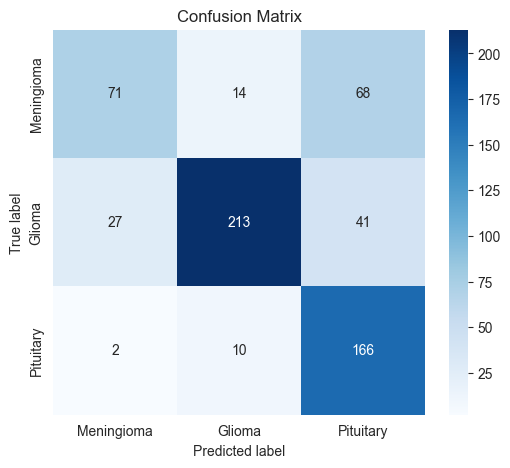

Classification Report:

              precision    recall  f1-score   support

  Meningioma     0.7100    0.4641    0.5613       153
      Glioma     0.8987    0.7580    0.8224       281
   Pituitary     0.6036    0.9326    0.7329       178

    accuracy                         0.7353       612
   macro avg     0.7375    0.7182    0.7055       612
weighted avg     0.7657    0.7353    0.7311       612



In [53]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Gather all predictions & labels on test set
model.eval()
y_true = []
y_pred = []

test_loader = data_module.test_dataloader()
with torch.no_grad():
    for images, masks, labels in test_loader:
        # move to same device as model
        images = images.to(model.device)
        labels = labels.to(model.device)

        logits = model(images)          # [B, num_classes]
        preds  = torch.argmax(logits, 1)  # [B]

        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# 2) Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Meningioma", "Glioma", "Pituitary"]  # adjust if needed

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

# 3) Full classification report
print("Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))


# 9. Check segmentation

In [58]:
import torch
import numpy as np

def dice_coef(y_true, y_pred, eps=1e-6):
    # flatten
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    intersection = (y_true * y_pred).sum()
    return (2. * intersection + eps) / (y_true.sum() + y_pred.sum() + eps)

model.eval()
dice_scores = []
for images, masks in data_module.test_dataloader():
    images = images.to(model.device)
    masks  = masks.to(model.device)

    # Unpack both, but only use the segmentation logits
    seg_logits, cls_logits = model(images)
    seg_preds = (seg_logits > 0.5).float()

    # Compute per‐image Dice
    for gt, pred in zip(masks, seg_preds):
        dice_scores.append(dice_coef(gt, pred).item())

print(f"Frozen‐decoder Seg Dice: {np.mean(dice_scores):.4f}")

 Missing keys: []
Unexpected keys: ['seg_decoder.0.weight', 'seg_decoder.1.weight', 'seg_decoder.1.bias', 'seg_decoder.1.running_mean', 'seg_decoder.1.running_var', 'seg_decoder.1.num_batches_tracked', 'seg_decoder.4.weight', 'seg_decoder.4.bias']


TypeError: new(): invalid data type 'str'

# Save model

In [38]:
trainer.save_checkpoint("checkpoints/classification_segFreezed.ckpt")

# 10. Unfreeze segmentaton